## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (8, 7)
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score
                             , precision_score
                             , recall_score
                             , roc_curve
                             , confusion_matrix
                             , plot_confusion_matrix
                             , precision_recall_curve
                             , auc
                            )

## Global Variables

In [2]:
interval = '60m' # time interval for data point
history = '2y' # time period for total history
perc_inc = 0.01 # 1% increase from interval to interval
symbol = 'TSLA' # tech etf

## Yahoo Finance

In [3]:
stock_df = yf.download(tickers = symbol
                       , interval = interval
                       , period = history
                       , prepost = False
                      )

[*********************100%***********************]  1 of 1 completed


In [4]:
stock_df.head(3)

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2018-06-22 14:30:00-04:00,335.533905,337.580200,333.519989,333.601196,333.601196,0
2018-06-22 15:30:00-04:00,333.500000,334.549988,332.000000,333.589996,333.589996,1366074
2018-06-25 09:30:00-04:00,330.429993,338.170013,328.230011,331.700012,331.700012,2678215


In [5]:
stock_df.tail(3)

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2020-06-22 13:30:00-04:00,999.400024,1000.889893,996.200012,996.849976,996.849976,499840
2020-06-22 14:30:00-04:00,996.757812,998.280029,995.450012,996.799988,996.799988,150503
2020-06-22 14:50:31-04:00,996.250000,996.250000,996.250000,996.250000,996.250000,0


## Create Percent Change

In [6]:
stock_df['Percent Change'] = (stock_df.Close - stock_df.Open) / stock_df.Open
stock_df.head(3)

,Open,High,Low,Close,Adj Close,Volume,Percent Change
Datetime,,,,,,,
2018-06-22 14:30:00-04:00,335.533905,337.580200,333.519989,333.601196,333.601196,0,-0.005760
2018-06-22 15:30:00-04:00,333.500000,334.549988,332.000000,333.589996,333.589996,1366074,0.000270
2018-06-25 09:30:00-04:00,330.429993,338.170013,328.230011,331.700012,331.700012,2678215,0.003844


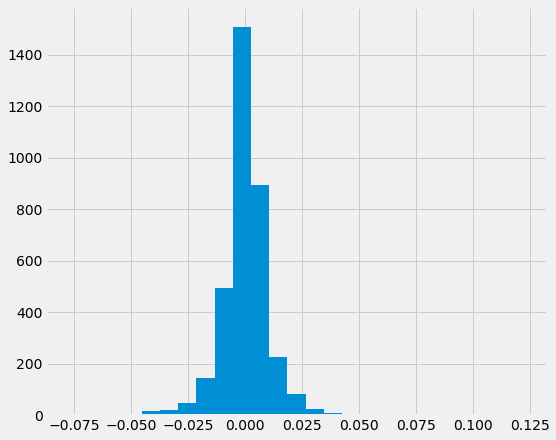

In [7]:
stock_df['Percent Change'].hist(bins=25);

In [8]:
stock_df['Percent Change'].quantile([0.84]) # 1 stdev from avg

0.84    0.007565
Name: Percent Change, dtype: float64

## Assign Direction

In [9]:
stock_df['Direction'] = np.where(stock_df['Percent Change'] > perc_inc
                                 , 1
                                 , 0
                                )

In [10]:
stock_df.tail(5)

,Open,High,Low,Close,Adj Close,Volume,Percent Change,Direction
Datetime,,,,,,,,
2020-06-22 11:30:00-04:00,995.799988,1000.749878,994.010071,998.229980,998.229980,631485,0.002440,0
2020-06-22 12:30:00-04:00,998.539978,1000.070007,996.190002,999.400024,999.400024,388648,0.000861,0
2020-06-22 13:30:00-04:00,999.400024,1000.889893,996.200012,996.849976,996.849976,499840,-0.002552,0
2020-06-22 14:30:00-04:00,996.757812,998.280029,995.450012,996.799988,996.799988,150503,0.000042,0
2020-06-22 14:50:31-04:00,996.250000,996.250000,996.250000,996.250000,996.250000,0,0.000000,0


## Shift Direction Column Up 1

Move decision column up by 1 cell so current hour of data will predict the next hour of data or whichever time frame interval is observed

In [11]:
direction = stock_df.Direction.values
print(f'Length Before: {len(direction)}')
direction = direction[1:len(direction)]
print(f'Length After: {len(direction)}')

Length Before: 3496
Length After: 3495


In [12]:
stock_df_one_off = stock_df.iloc[0:stock_df.shape[0]-1]
stock_df_one_off['Direction'] = direction
stock_df_one_off.shape

(3495, 8)

In [13]:
stock_df_one_off.tail(5)

,Open,High,Low,Close,Adj Close,Volume,Percent Change,Direction
Datetime,,,,,,,,
2020-06-22 10:30:00-04:00,1003.500000,1003.654114,990.020020,995.799988,995.799988,1199682,-0.007673,0
2020-06-22 11:30:00-04:00,995.799988,1000.749878,994.010071,998.229980,998.229980,631485,0.002440,0
2020-06-22 12:30:00-04:00,998.539978,1000.070007,996.190002,999.400024,999.400024,388648,0.000861,0
2020-06-22 13:30:00-04:00,999.400024,1000.889893,996.200012,996.849976,996.849976,499840,-0.002552,0
2020-06-22 14:30:00-04:00,996.757812,998.280029,995.450012,996.799988,996.799988,150503,0.000042,0


In [14]:
stock_df_one_off.Direction.value_counts()

0    3116
1     379
Name: Direction, dtype: int64

## Balance 1's and 0's

In [15]:
ones_count = stock_df_one_off['Direction'].value_counts()[1]
ones_count

379

In [16]:
stock_df_bal = stock_df_one_off.groupby('Direction').apply(lambda x: x.sample(n=ones_count)).reset_index(drop=True)
stock_df_bal.shape

(758, 8)

In [17]:
stock_df_bal['Direction'].value_counts() # try bootstrapping and upsampling 

1    379
0    379
Name: Direction, dtype: int64

## Check for NaN's

In [18]:
stock_df_bal.isna().sum()

Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
Percent Change    0
Direction         0
dtype: int64

In [19]:
stock_df_bal.dropna(axis=0, inplace=True)

In [20]:
stock_df_bal.isna().sum()

Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
Percent Change    0
Direction         0
dtype: int64

## Train Test Split

In [21]:
X = stock_df_bal.drop(columns=['Percent Change', 'Direction'])
y = stock_df_bal['Direction']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X
                                                    , y
                                                    , test_size=0.15
                                                    , random_state = 42
                                                   )

## Random Forest Classifier

In [23]:
rfc = RandomForestClassifier(n_estimators = 125 # how many trees use grid search   
                             , random_state = 42
                             , verbose = 1
                             , n_jobs = -1 # uses all your processer cores
                             , max_depth = 5 # height of tree
                             , max_features = 4 # random sampling of features 
                             # need to tune n_estimators, n max_depth, max_features
                            )

In [24]:
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

y_probs = rfc.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.0s finished


## Receiver Operating Characteristic (ROC) Curve

In [25]:
roc_score = roc_auc_score(y_test
                          , y_probs
                         )
roc_score

0.6262345679012344

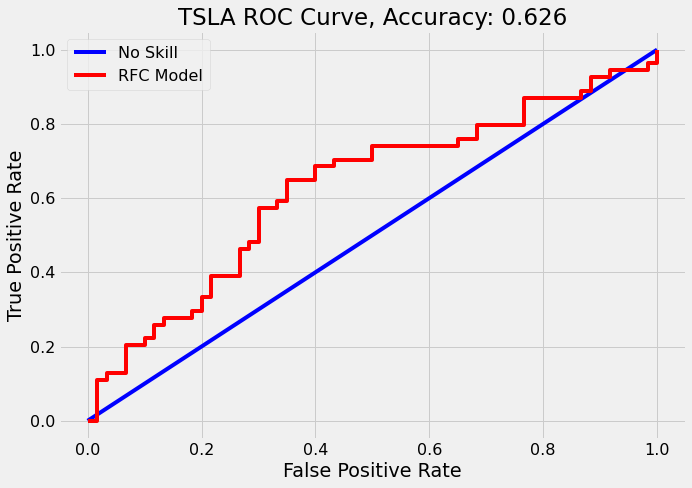

In [26]:
plt.rcParams['font.size'] = 16
plt.figure(figsize=(10,7))

# No Skill Line Data
base_fpr, base_tpr, _ = roc_curve(y_test
                                  , [1 for _ in range(len(y_test))]
                                 ) 

# Model Data
model_fpr, model_tpr, _ = roc_curve(y_test
                                    , y_probs
                                   )

plt.plot(base_fpr
         , base_tpr
         , 'b'
         , label='No Skill'
        )

plt.plot(model_fpr
         , model_tpr
         , 'r'
         , label='RFC Model'
        )

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{symbol} ROC Curve, Accuracy: {round(roc_score, 3)}')
plt.legend();

## Precision Recall Curve

In [27]:
# Precision Recall Data
rf_prec, rf_recall, _ = precision_recall_curve(y_test
                                             , y_probs
                                            )

auc_score = auc(rf_recall, rf_prec)
auc_score

0.5902256663182972

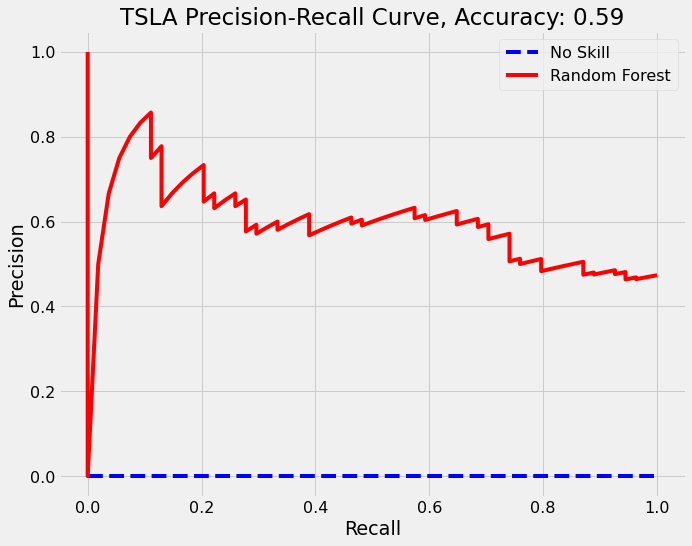

In [28]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10, 8)



# No Skill Line
plt.plot([0, 0]
         , linestyle = '--'
         , color = 'b'
         , label = 'No Skill'
        )

# PR Line
plt.plot(rf_recall
         , rf_prec
         , color = 'r'
         , label = 'Random Forest'
        )

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'{symbol} Precision-Recall Curve, Accuracy: {round(auc_score, 3)}')
plt.legend();

## Confusion Matrix

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.1s finished


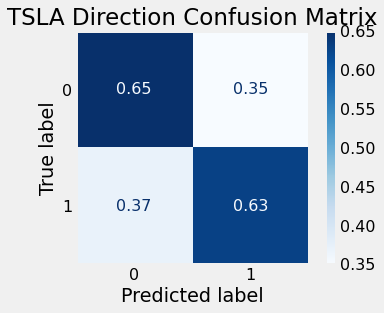

In [29]:
plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams['font.size'] = 16
disp = plot_confusion_matrix(rfc
                             , X_test
                             , y_test
                             , cmap = plt.cm.Blues
                             , normalize = 'true'
                            )
disp.ax_.grid(False)
disp.ax_.set_title(f'{symbol} Direction Confusion Matrix');

## Feature Importances

In [30]:
features_df = pd.DataFrame({'Feature': X_train.columns
                            , 'Importances': rfc.feature_importances_
                           }).sort_values('Importances'
                                          , ascending=False
                                         )
features_df

,Feature,Importances
5,Volume,0.480248
1,High,0.140273
0,Open,0.119367
3,Close,0.093699
2,Low,0.089809
4,Adj Close,0.076603


## Make A Prediction

In [31]:
stock_df.tail(3)

,Open,High,Low,Close,Adj Close,Volume,Percent Change,Direction
Datetime,,,,,,,,
2020-06-22 13:30:00-04:00,999.400024,1000.889893,996.200012,996.849976,996.849976,499840,-0.002552,0
2020-06-22 14:30:00-04:00,996.757812,998.280029,995.450012,996.799988,996.799988,150503,0.000042,0
2020-06-22 14:50:31-04:00,996.250000,996.250000,996.250000,996.250000,996.250000,0,0.000000,0


In [32]:
last = stock_df.drop(columns=['Percent Change', 'Direction']).iloc[-1]
last

Open         996.25
High         996.25
Low          996.25
Close        996.25
Adj Close    996.25
Volume         0.00
Name: 2020-06-22 14:50:31-04:00, dtype: float64

In [33]:
if rfc.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {symbol} on the {interval} for {round(perc_inc * 100, 1)}% increase.')
else:
    print(f'Sell or hold {symbol} on the {interval} interval for expected {round(perc_inc * 100, 1)}% increase.')

Sell or hold TSLA on the 60m interval for expected 1.0% increase.


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.1s finished


Try Gradient Boosting: n_estimators, n_splits, n_depths, learning rate, etc...